In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [4]:
week_labels = [20180226, 20180305, 20180312, 20180319, 
               20180326, 20180402, 20180409, 20180416, 20180423]

In [5]:
%%time
weeks = []
for name in week_labels:
    weeks.append(pd.read_feather(PROCESSED/f'week_{name % 10000:04}_diffscount.feather'))

CPU times: user 5.16 s, sys: 3.22 s, total: 8.37 s
Wall time: 13.9 s


## Preprocessing

In [10]:
from functools import cmp_to_key
from src.utils import composite_rating_cmp
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
ratings = list(isin.CompositeRating.value_counts().index)
ratings = sorted(ratings, key=cmp_to_key(composite_rating_cmp), reverse=True)
rank = {k: i for i, k in enumerate(ratings)}

In [12]:
%%time
for n, w in zip(week_labels, weeks):
    print(n)
    w['CompositeRating']  = w.CompositeRating.apply(lambda x: rank[x])

20180226
20180305
20180312
20180319
20180326
20180402
20180409
20180416
20180423
CPU times: user 2.63 s, sys: 284 ms, total: 2.91 s
Wall time: 2.9 s


In [13]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [14]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [15]:
from src.utils import apply_cats
for col in cat_cols:
    weeks[-1][col] = weeks[-1][col].astype('category').cat.as_ordered()
for w in weeks[:-1]:
    apply_cats(w, weeks[-1])

for w in weeks:
    for col in cat_cols:
        w[col] = w[col].cat.codes

## Model

In [16]:
from src.utils import run_model
from lightgbm import LGBMClassifier
metric_names = ['auc']

In [17]:
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    print(train['TradeDateKey'].unique(), 
          val['TradeDateKey'].unique(), 
          test['TradeDateKey'].unique())

[20180226] [20180305] [20180423]
[20180305] [20180312] [20180423]
[20180312] [20180319] [20180423]
[20180319] [20180326] [20180423]
[20180326] [20180402] [20180423]
[20180402] [20180409] [20180423]
[20180409] [20180416] [20180423]
[20180416] [20180423] [20180423]


In [20]:
%%time
results = None
output = []
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], weeks[-2], weeks[-1]
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    if pred_col in val.columns: # when test acts as validation
        X_val, y_val = None, None
    else:
        X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
        
    y_test, _, results, model = run_model(
            LGBMClassifier(n_estimators=100),
            X_train, y_train, X_val, y_val, X_test,
            metric_names, results, 
            params_desc='n_estimators=100',
            dataset_desc=f'{week_labels[i]}_diffcounts', 
            early_stopping=False)
    output.append([y_test, model])

LGBMClassifier 

[1]	valid_0's auc: 0.590414
[2]	valid_0's auc: 0.590868
[3]	valid_0's auc: 0.586784
[4]	valid_0's auc: 0.592726
[5]	valid_0's auc: 0.594717
[6]	valid_0's auc: 0.60022
[7]	valid_0's auc: 0.600819
[8]	valid_0's auc: 0.600407
[9]	valid_0's auc: 0.610876
[10]	valid_0's auc: 0.610777
[11]	valid_0's auc: 0.611668
[12]	valid_0's auc: 0.610109
[13]	valid_0's auc: 0.612225
[14]	valid_0's auc: 0.613355
[15]	valid_0's auc: 0.613929
[16]	valid_0's auc: 0.614046
[17]	valid_0's auc: 0.615942
[18]	valid_0's auc: 0.620998
[19]	valid_0's auc: 0.625899
[20]	valid_0's auc: 0.6292
[21]	valid_0's auc: 0.629923
[22]	valid_0's auc: 0.629433
[23]	valid_0's auc: 0.631261
[24]	valid_0's auc: 0.627566
[25]	valid_0's auc: 0.629232
[26]	valid_0's auc: 0.630106
[27]	valid_0's auc: 0.631134
[28]	valid_0's auc: 0.631781
[29]	valid_0's auc: 0.630286
[30]	valid_0's auc: 0.629905
[31]	valid_0's auc: 0.63182
[32]	valid_0's auc: 0.632413
[33]	valid_0's auc: 0.629376
[34]	valid_0's auc: 0.629418
[35]	valid

In [21]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=100,9.53,0.801939,0.612257
1,20180305_diffcounts,LGBMClassifier,n_estimators=100,6.91,0.780995,0.656922
2,20180312_diffcounts,LGBMClassifier,n_estimators=100,6.56,0.781129,0.683885
3,20180319_diffcounts,LGBMClassifier,n_estimators=100,7.22,0.797862,0.695717
4,20180326_diffcounts,LGBMClassifier,n_estimators=100,8.12,0.820903,0.666326
5,20180402_diffcounts,LGBMClassifier,n_estimators=100,6.85,0.818544,0.726473
6,20180409_diffcounts,LGBMClassifier,n_estimators=100,7.59,0.821138,0.767700
7,20180416_diffcounts,LGBMClassifier,n_estimators=100,7.26,0.833571,0.833571


In [31]:
val_preds = []
val_actuals = []
for o in output[:-1]:
    m = o[1]
    val = weeks[-2]
    X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    y_val_pred = m.predict_proba(X_val)[:,1]
    val_preds.append(y_val_pred)
    val_actuals.append(y_val)

In [34]:
from sklearn.metrics import roc_auc_score
for actual, pred in zip(val_actuals, val_preds):
    print(roc_auc_score(actual, pred))

0.6122566633347771
0.6569224087558102
0.6838854415393611
0.6957169568763419
0.6663262395930394
0.7264727773585471
0.767699689646886


In [281]:
# simple mean
val_preds_mean = np.mean(val_preds, axis=0)
roc_auc_score(val_actuals[0], val_preds_mean)

0.7567214092213613

In [280]:
# weighted mean (regular intervals)
weights = ([1 - (len(val_preds)-i-1) * 0.15 for i in range(len(val_preds))])
val_preds_mean = np.sum([pred * w for pred, w in zip(val_preds, weights)], axis=0) / sum(weights)
roc_auc_score(val_actuals[0], val_preds_mean)

0.7702040043869192

In [132]:
# weighted mean (exp intervals)
n = len(val_preds) + 1
xs, ys = [], []
for exponent in [0, 1/8, 1/4, 1/2, 1, 2, 4, 8]:
    weights = np.power(np.arange(0, n) / (n-1), exponent)[1:]
    val_preds_mean = np.sum([pred * w for pred, w in zip(val_preds, weights)], axis=0) / sum(weights)
    xs.append(exponent)
    ys.append(roc_auc_score(val_actuals[0], val_preds_mean))
    print(xs[-1], ys[-1])

0 0.7567214092213613
0.125 0.7597949461132716
0.25 0.7622825458437554
0.5 0.765864047340725
1 0.7696859362333902
2 0.772029300561758
4 0.7717438221594748
8 0.7701802990666361


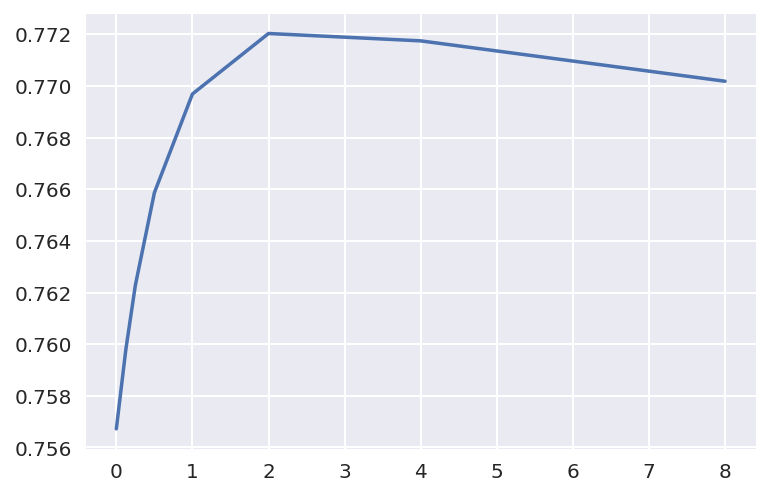

In [134]:
plt.plot(xs, ys)

In [153]:
# weighted mean (exp intervals)
n = len(val_preds) + 1
xs, ys = [], []
for exponent in [1.5, 2, 2.3, 2.5, 2.7, 3, 4]:
    weights = np.power(np.arange(0, n) / (n-1), exponent)[1:]
    val_preds_mean = np.sum([pred * w for pred, w in zip(val_preds, weights)], axis=0) / sum(weights)
    xs.append(exponent)
    ys.append(roc_auc_score(val_actuals[0], val_preds_mean))
    print(xs[-1], ys[-1])

1.5 0.7713635455618311
2 0.772029300561758
2.3 0.7721797772628404
2.5 0.7722138942658845
2.7 0.772210224964826
3 0.7721543611654156
4 0.7717438221594748


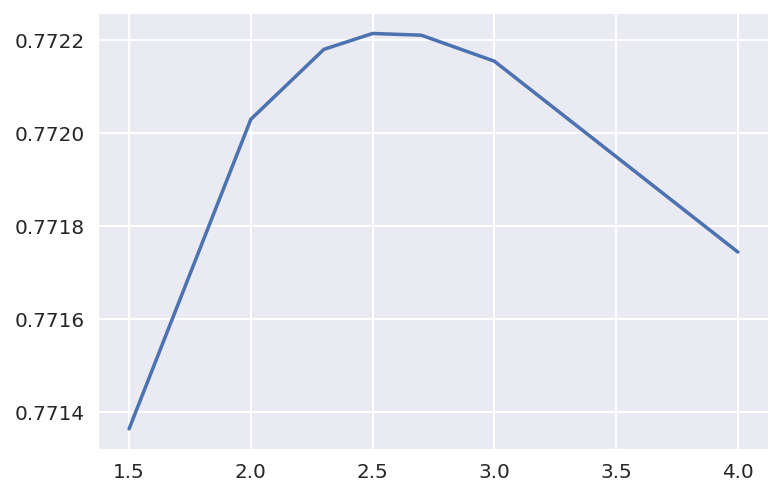

In [154]:
plt.plot(xs, ys)

In [22]:
# first 5 predictions (2018 data)
np.array([x[0] for x in output])[:,:5]

array([[0.04830683, 0.14661346, 0.02108042, 0.02342775, 0.01699016],
       [0.0402605 , 0.11248656, 0.02260455, 0.11036023, 0.01674016],
       [0.04305989, 0.08595892, 0.02802016, 0.04930967, 0.10592109],
       [0.03248463, 0.07347365, 0.02470694, 0.02972468, 0.02127365],
       [0.02546837, 0.07804705, 0.01907794, 0.0229122 , 0.01982609],
       [0.06169568, 0.1038008 , 0.03608943, 0.04581292, 0.04585235],
       [0.06466785, 0.14202234, 0.01576259, 0.04365328, 0.02487517],
       [0.04990233, 0.06209097, 0.04534148, 0.04804753, 0.04580806]])

In [166]:
n = len(val_preds) + 2
exponent = 2.5
weights = np.power(np.arange(0, n) / (n-1), exponent)[1:]
test[target_col] = np.sum([x[0] * w for x, w in zip(output, weights)], axis=0) / sum(weights)

In [258]:
test[target_col] = np.mean([x[0] for x in output], axis=0)

## Submission

In [259]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [260]:
submission[target_col].describe()

count    484758.000000
mean          0.030178
std           0.031824
min           0.002498
25%           0.012778
50%           0.023750
75%           0.038233
max           0.861081
Name: CustomerInterest, dtype: float64

In [261]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.045731
1,c2cc6cc2a8,0.100562
2,a8e94f6344,0.026585
3,758bae1e35,0.046656
4,02ab378ee8,0.037161


In [170]:
submission.to_csv(SUBMISSIONS/'17-lgbm_8weeks_diffscounts_2.5pow_mean_0226-0416.csv', index=False)

## Error analysis

In [171]:
for w in weeks:
    print(w.CustomerIdx.nunique())

2559
2501
2499
2502
2561
2503
2503
2503
2495


In [206]:
all_weeks = pd.DataFrame()
for w in weeks:
    all_weeks = all_weeks.append(w.fillna(0).groupby(['TradeDateKey', 'CustomerIdx'], 
                                    as_index=False)['CustomerInterest'].max())

In [207]:
all_weeks = all_weeks.pivot_table(values='CustomerInterest', index='TradeDateKey', columns='CustomerIdx', aggfunc='max')

In [208]:
activity_count = np.sum(all_weeks, axis=0)
cols = all_weeks.columns
activity_count, cols = zip(*sorted(zip(activity_count, cols), reverse=True))

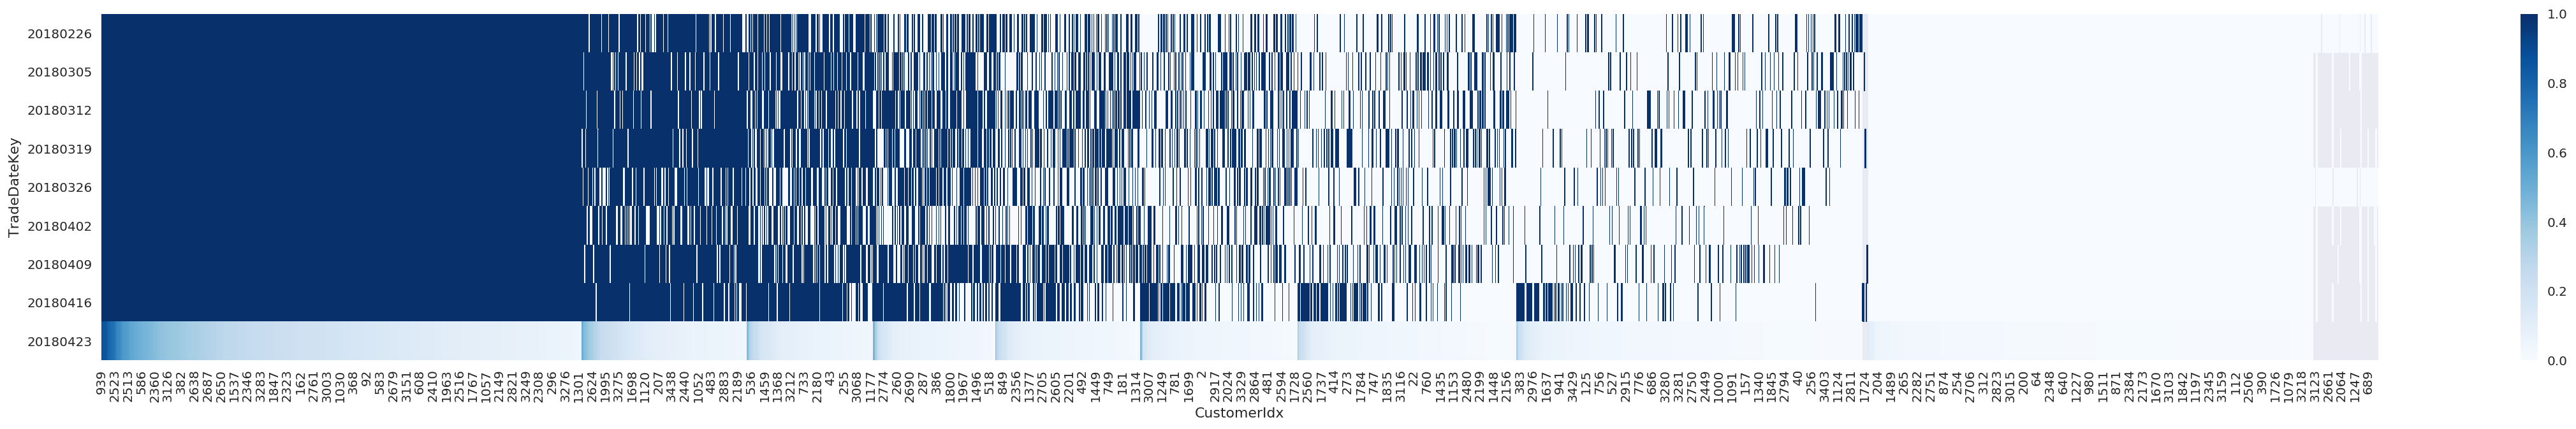

In [211]:
fig, ax = plt.subplots(figsize=(40,5))
sns.heatmap(all_weeks[list(cols)], cmap='Blues')

In [234]:
all_weeks = pd.DataFrame()
for w in weeks:
    all_weeks = all_weeks.append(w.fillna(0).groupby(['TradeDateKey', 'CustomerIdx'], 
                                    as_index=False)['CustomerInterest'].sum())

In [228]:
all_weeks[all_weeks.TradeDateKey==20180423].CustomerInterest.describe(percentiles=np.arange(0.1, 0.9, 0.1))

count    2495.000000
mean        5.646207
std        24.169855
min         0.005377
10%         0.020500
20%         0.049173
30.0%       0.096146
40%         0.208484
50%         0.432811
60%         0.869229
70%         1.751161
80%         3.954783
max       586.438299
Name: CustomerInterest, dtype: float64

In [232]:
all_weeks['CustomerInterest'] = all_weeks.CustomerInterest.clip(0,10)

In [240]:
all_weeks = all_weeks.pivot_table(values='CustomerInterest', index='TradeDateKey', columns='CustomerIdx', aggfunc='max')
activity_count = np.sum(all_weeks, axis=0)
cols = all_weeks.columns
activity_count, cols = zip(*sorted(zip(activity_count, cols), reverse=True))
cols = list(cols)

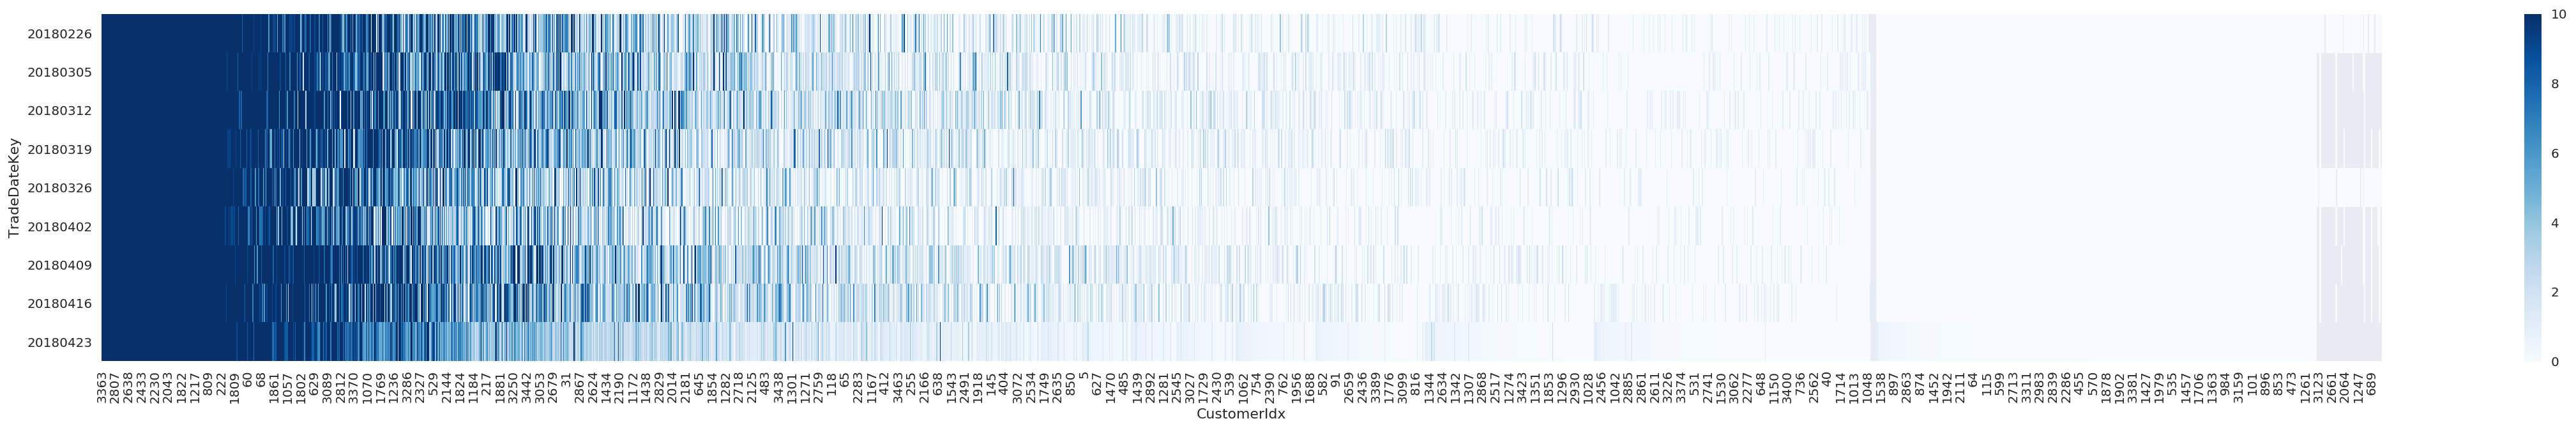

In [223]:
fig, ax = plt.subplots(figsize=(40,5))
sns.heatmap(all_weeks[cols], cmap='Blues')

In [236]:
cols[-1]

38

In [266]:
test[test.CustomerIdx==2574][['IsinIdx', 'BuySell', 'CustomerInterest']].describe()

,IsinIdx,BuySell,CustomerInterest
count,10088.000000,10088.000000,10088.000000
mean,11019.267248,0.500000,0.068314
std,4640.716739,0.500025,0.058913
min,7.000000,0.000000,0.011166
25%,7269.750000,0.000000,0.034727
50%,10594.500000,0.500000,0.047646
75%,14005.500000,1.000000,0.075132
max,27245.000000,1.000000,0.634428


In [267]:
test[test.CustomerIdx==2574][['IsinIdx', 'BuySell', 'CustomerInterest']].sort_values('CustomerInterest', ascending=False).iloc[:500].describe()

,IsinIdx,BuySell,CustomerInterest
count,500.000000,500.000000,500.000000
mean,9746.114000,0.406000,0.265488
std,3733.465881,0.491576,0.068238
min,4320.000000,0.000000,0.191438
25%,6111.000000,0.000000,0.214597
50%,9393.000000,0.000000,0.246291
75%,12750.500000,1.000000,0.292015
max,17881.000000,1.000000,0.634428


In [271]:
test[test.CustomerIdx==2308][['IsinIdx', 'BuySell', 'CustomerInterest']].describe()

,IsinIdx,BuySell,CustomerInterest
count,142.000000,142.00000,142.000000
mean,9096.394366,0.50000,0.020794
std,3561.199178,0.50177,0.016064
min,4406.000000,0.00000,0.004999
25%,5746.500000,0.00000,0.008245
50%,8066.000000,0.50000,0.011774
75%,12407.000000,1.00000,0.038085
max,15792.000000,1.00000,0.065738


In [272]:
test[test.CustomerIdx==2308][['IsinIdx', 'BuySell', 'CustomerInterest']].sort_values('CustomerInterest', ascending=False).iloc[:500].describe()

,IsinIdx,BuySell,CustomerInterest
count,142.000000,142.00000,142.000000
mean,9096.394366,0.50000,0.020794
std,3561.199178,0.50177,0.016064
min,4406.000000,0.00000,0.004999
25%,5746.500000,0.00000,0.008245
50%,8066.000000,0.50000,0.011774
75%,12407.000000,1.00000,0.038085
max,15792.000000,1.00000,0.065738


In [268]:
len(cols)

2577

In [270]:
all_weeks[cols[500:505]]

CustomerIdx,2308,3314,3069,2121,3053
TradeDateKey,,,,,
20180226,2.000000,6.000000,7.000000,6.000000,3.000000
20180305,2.000000,5.000000,2.000000,5.000000,0.000000
20180312,11.000000,6.000000,3.000000,4.000000,4.000000
20180319,9.000000,4.000000,3.000000,6.000000,3.000000
20180326,1.000000,6.000000,19.000000,4.000000,4.000000
20180402,7.000000,7.000000,7.000000,0.000000,8.000000
20180409,10.000000,3.000000,0.000000,5.000000,12.000000
20180416,1.000000,5.000000,1.000000,10.000000,7.000000
20180423,3.026951,3.785183,3.704251,5.623528,3.841162


In [273]:
# active users with many bonds (higher probs) hide less active users (smaller probs), this impacts auc metric

## Modify order

In [276]:
weeks[-2].head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,DaysSinceBuySell,DaysSinceTransaction,DaysSinceCustomerActivity,DaysSinceBondActivity,DaysCountBuySell,DaysCountTransaction,DaysCountCustomerActivity,DaysCountBondActivity,Sector,Subsector,Region_x,Country,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region_y,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,20180416,0,21856,0,0.0,289,289,34,26,0,0,14,8,0,21,1,30,1555,20190114,20140114,4,15,1,1,1,1,0,14,6,228,5,600000000.0,0
1,20180416,0,21856,1,0.0,289,289,34,26,0,0,14,8,0,21,1,30,1555,20190114,20140114,4,15,1,1,1,1,0,14,6,228,5,600000000.0,0
2,20180416,0,24944,0,0.0,289,35,34,26,0,1,14,22,0,21,1,30,1089,20230817,20160817,4,15,1,1,1,1,0,0,6,210,5,590000000.0,0
3,20180416,0,24944,1,0.0,35,35,34,26,1,1,14,22,0,21,1,30,1089,20230817,20160817,4,15,1,1,1,1,0,0,6,210,5,590000000.0,0
4,20180416,0,25992,0,0.0,48,48,34,5,2,2,14,43,0,21,1,30,601,20200601,20170601,4,15,1,1,1,1,0,17,1,140,5,500000000.0,0


In [279]:
len(weeks[-2]), len(val_preds)

(493590, 7)

In [288]:
val = weeks[-2].iloc[:,:5].copy()
val['Pred'] = val_preds_mean

In [289]:
val.sort_values('Pred', ascending=False).head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Pred
93614,20180416,939,15297,0,1.0,0.848923
305536,20180416,2389,15297,0,1.0,0.846421
34286,20180416,416,15297,0,1.0,0.846018
305537,20180416,2389,15297,1,1.0,0.840727
89152,20180416,917,15297,0,1.0,0.837204


In [309]:
customers = pd.DataFrame()
for w in weeks[:-2]:
    customers = customers.append(w.fillna(0).groupby(['TradeDateKey', 'CustomerIdx'], 
                                    as_index=False)['CustomerInterest'].sum())
customers = customers.groupby('CustomerIdx').agg({'CustomerInterest': 'mean'})

In [311]:
customers.sort_values('CustomerInterest',ascending=False).head()

,CustomerInterest
CustomerIdx,
2574,661.428571
2398,391.714286
176,371.142857
1856,355.285714
3122,350.857143


In [312]:
customers = customers.to_dict()
customers = customers['CustomerInterest']
customers = {k: np.ceil(customers[k]) for k in customers}

In [348]:
from collections import defaultdict

In [399]:
%%time
customer_counter = defaultdict(lambda : 0)
zeroed = 0
val['NewPred'] = 0
val = val.sort_values('Pred', ascending=False)
new_preds = []
for idx, row in val.iterrows():
    customer_counter[row.CustomerIdx] += 1
    if row.CustomerIdx not in customers or customer_counter[row.CustomerIdx] <= 20 * customers[row.CustomerIdx]:
        new_preds.append(row['Pred'])
    else:
        new_preds.append(0)
        zeroed += 1
val['NewPred'] = new_preds

CPU times: user 26.1 s, sys: 12 ms, total: 26.1 s
Wall time: 26.1 s


In [400]:
zeroed, len(val)

(159444, 493590)

In [401]:
val.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Pred,NewPred
93614,20180416,939,15297,0,1.0,0.848923,0.848923
305536,20180416,2389,15297,0,1.0,0.846421,0.846421
34286,20180416,416,15297,0,1.0,0.846018,0.846018
305537,20180416,2389,15297,1,1.0,0.840727,0.840727
89152,20180416,917,15297,0,1.0,0.837204,0.837204


In [402]:
roc_auc_score(val.CustomerInterest, val.Pred)

0.7567214092213613

In [403]:
val.NewPred.describe()

count    493590.000000
mean          0.026536
std           0.035601
min           0.000000
25%           0.000000
50%           0.023875
75%           0.037827
max           0.848923
Name: NewPred, dtype: float64

In [404]:
roc_auc_score(val.CustomerInterest, val.NewPred)

0.7512391351118093

In [398]:
roc_auc_score(val.CustomerInterest, val.NewPred)

0.7552971916249747

In [391]:
roc_auc_score(val.CustomerInterest, val.NewPred)

0.7550510822386587

In [385]:
roc_auc_score(val.CustomerInterest, val.NewPred)

0.7206123177361955